In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import random as rm
import math
import cv2
from tkinter import *
from tkinter import messagebox
from PIL import Image, ImageTk
import random

In [19]:
# import the image
im1 = cv2.imread('img/im01.jpg', cv2.IMREAD_COLOR)
im2 = cv2.imread('img/im02.jpg', cv2.IMREAD_COLOR)
im3 = cv2.imread('img/im03.jpg', cv2.IMREAD_COLOR)
im4 = cv2.imread('img/im04.jpg', cv2.IMREAD_COLOR)
im5 = cv2.imread('img/im05.jpg', cv2.IMREAD_COLOR)
img1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(im3, cv2.COLOR_BGR2RGB)
img4 = cv2.cvtColor(im4, cv2.COLOR_BGR2RGB)
img5 = cv2.cvtColor(im5, cv2.COLOR_BGR2RGB)

In [20]:
# show input image
input_images = np.hstack((im1, im2, im3, img4))
cv2.imshow('First Four', input_images)
cv2.imshow('Last', img5)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

In [21]:
# mini square
def mini_square(des1, des2):
    [p1, n] = des1.shape
    [p2, n] = des2.shape

    # find mini distance position
    # return the matches relationship of both sides
    matches1 = []
    for j in range(0, p1):
        dis = np.zeros([p2, 1])
        for k in range(0, p2):
            v = des1[j] - des2[k]
            dis[k] = np.dot(v, v.T)

        # find the mini position
        pos = np.argmin(dis)
        # _distance should not be float
        tmp = int(dis[pos])

        # store the position in DMatch
        matches1.append(cv2.DMatch(_distance=tmp, _queryIdx=j, _trainIdx=pos, _imgIdx=0))

    matches2 = []
    for j in range(0, p2):
        dis = np.zeros([p1, 1])
        for k in range(0, p1):
            v = des2[j] - des1[k]
            dis[k] = np.dot(v, v.T)

        # find the mini position
        pos = np.argmin(dis)
        tmp = int(dis[pos])

        # store the position in DMatch
        matches2.append(cv2.DMatch(_distance=tmp, _queryIdx=j, _trainIdx=pos, _imgIdx=0))

    # matches points that are same in query index and train index
    matches = []
    for i in matches1:
        for j in matches2:
            if i.queryIdx == j.trainIdx and i.trainIdx == j.queryIdx:
                matches.append(i)

    return matches


In [22]:
# Find SIFT and return Homography Matrix
def SIFT(im1, im2):
    # im1 and im2 are grayscale image

    # Initialize SIFT 
    sift = cv2.SIFT_create()

    # turn to grayscale
    im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    # Extract keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(im1, None)
    kp2, des2 = sift.detectAndCompute(im2, None)

    # match the points
    # using DMatch instead of matrix. matrix not so powerful and easily went wrong
    matches = mini_square(des1, des2)

    #     # Bruteforce matcher on the descriptors
    #         another way to match the pairs of points using KNN

    #     bruteforce=cv2.BFMatcher()
    #     matches=bruteforce.knnMatch(des1,des2, k=2)

    #     # Make sure that the matches are good
    #     verify_ratio=0.8 
    #     verified_matches=[]
    #     for m1,m2 in matches:
    #         # Add to array only if it's a good match
    #         if m1.distance<0.8*m2.distance:
    #             #turn DMatch to matrix
    #             verified_matches.append([m1.queryIdx,m1.trainIdx])

    #     verified_matches = np.matrix(verified_matches)

    # Mimnum number of matches
    min_matches = 8
    if len(matches) > min_matches:
        return matches, kp1, kp2
    else:
        print('Error: Not enough matches')
        exit()

In [23]:
# homography computing
def hmat(points):
    row = len(points)
    n_mat = int(row / 2)
    A = np.zeros([row, 9])

    for i in range(0, n_mat):
        h1_x = points[i][0]
        h1_y = points[i][1]
        h2_x = points[i + n_mat][0]
        h2_y = points[i + n_mat][1]
        A[2 * i][:] = [h1_x, h1_y, 1, 0, 0, 0, -h2_x * h1_x, -h2_x * h1_y, -h2_x]
        A[2 * i + 1][:] = [0, 0, 0, h1_x, h1_y, 1, -h2_y * h1_x, -h2_y * h1_y, -h2_y]

    _, _, vt = linalg.svd(A)
    H = vt[-1].reshape(3, 3)
    H = H / H[2, 2]  # H(3,3) = 1

    return H


# count inliers
def inlier(H, mp, matches, threshold):
    row = len(mp)
    p1 = mp[:, 0:2]
    p2 = mp[:, 2:4]

    x1 = np.concatenate((p1, np.ones([row, 1])), axis=1)
    # transfer 
    x2 = np.dot(H, x1.T)
    x2 = x2[0:2, :] / x2[2, :]
    es_p2 = x2[0:2, :].T

    # distance
    diff = p2 - es_p2
    sq = diff * diff
    dis = np.sqrt(sq[:, 0] + sq[:, 1])

    # calculate the number of points that distance < threshold
    # inliers' position
    match = []
    for i in range(0, row):
        if dis[i] < threshold:
            match.append(matches[i])

    return match


# RANSAC + Homography
def homo_ransac(kp1, kp2, matches, repeat):
    # n the pairs of keypoints selected randomly (n >= 4)
    n = 4
    # loop times
    loop = repeat
    # HH the largest inliers H
    HH = []
    # threshold of the inliers distance
    threshold = 1
    # inliers box
    num_in = 0

    # change the kp1 and kp2 from tuple to list
    N = len(matches)
    k1 = np.zeros([N, 2])
    k2 = np.zeros([N, 2])

    # Get the coordinate of keypoint
    for i in range(N):
        for j in range(2):
            k1[i, j] = kp1[matches[i].queryIdx].pt[j]
            k2[i, j] = kp2[matches[i].trainIdx].pt[j]

    # matched points
    mp = np.concatenate((k1, k2), axis=1)
    match_best = []
    for i in range(0, loop):
        # Use four random pair of keypoints to compute the homography matrix
        rdm = random.sample(range(0, N), 4)
        points = np.array([[k1[rdm[0]][0], k1[rdm[0]][1]], [k1[rdm[1]][0], k1[rdm[1]][1]],
                           [k1[rdm[2]][0], k1[rdm[2]][1]], [k1[rdm[3]][0], k1[rdm[3]][1]],
                           [k2[rdm[0]][0], k2[rdm[0]][1]], [k2[rdm[1]][0], k2[rdm[1]][1]],
                           [k2[rdm[2]][0], k2[rdm[2]][1]], [k2[rdm[3]][0], k2[rdm[3]][1]]])

        # compute H
        H = hmat(points)

        # count inliers
        match = inlier(H, mp, matches, threshold)

        # keep the max inliers parameter
        if len(match) > num_in:
            num_in = len(match)
            HH = H
            match_best = match

    return HH, match_best


# transform h1 to h2
def get_size(h1, H):
    [row, col, c] = h1.shape

    # 4 cornor of the image h1
    lt = np.array([[0, 0, 1]])
    rt = np.array([[0, col, 1]])
    lb = np.array([[row, 0, 1]])
    rb = np.array([[row, col, 1]])

    # edge matrix
    edge = np.concatenate((lt, rt, lb, rb), axis=0).T

    T_edge = np.dot(H, edge)
    # normalize
    T_edge = T_edge[0:2, :] / T_edge[2, :]
    T_edge = T_edge

    return np.max(T_edge[0, :]), np.min(T_edge[0, :]), np.max(T_edge[1, :]), np.min(T_edge[1, :])


# build a canvas
def get_canvas(im1, im2, Hi):
    # Hi is im2 to im1
    [row1, col1, c] = im1.shape
    [row2, col2, c] = im2.shape

    # get the edge
    [x_max, x_min, y_max, y_min] = get_size(im2, Hi)
    print([x_min, x_max, y_min, y_max])
    x_minus = int(np.min([0, x_min]) - 10)
    x_plus = int(np.max([0, x_max - row1]) + 10)
    y_minus = int(np.min([0, y_min]) - 10)
    y_plus = int(np.max([0, y_max - col1]) + 10)

    # x direction adding space
    add_x_minus = np.zeros([-x_minus, col1, c])
    add_x_plus = np.zeros([x_plus, col1, c])

    # y direction adding space
    add_y_minus = np.zeros([-x_minus + row1 + x_plus, -y_minus, c])
    add_y_plus = np.zeros([-x_minus + row1 + x_plus, y_plus, c])

    # concatenate the adding space with im1
    canvas = np.concatenate((add_x_minus, im1, add_x_plus), axis=0)
    canvas = np.concatenate((add_y_minus, canvas, add_y_plus), axis=1)

    return canvas.astype(int), [x_minus, y_minus]


def trans2im1(canvas, im2, Hi, compensation, step):
    # the wight of the im1 when overlay
    w = 0.6

    # step of the transmitting 1/step
    [row, col, c] = im2.shape

    # draw im2 on the canvas
    for j in range(0, row * step):
        for k in range(0, col * step):
            # positon: points of im2 in im1 plane 
            p = np.array([[j / step, k / step, 1]]).T
            Tp = np.dot(Hi, p)

            # normalize and move the image
            x2 = int(round(Tp[0, 0] / Tp[2, 0]) - compensation[0])
            y2 = int(round(Tp[1, 0] / Tp[2, 0]) - compensation[1])

            # position in im1
            x1 = int(j / step)
            y1 = int(k / step)

            if np.any(canvas[x2, y2] > 0):
                canvas[x2, y2] = w * canvas[x2, y2][:] + (1 - w) * im2[x1, y1][:]
            else:
                canvas[x2, y2] = im2[x1, y1][:]

    return canvas.astype(int)




[[ 1.80607233e+00  5.59693247e-01 -2.01935545e+02]
 [-1.08867009e-01  2.23687280e+00 -6.58338754e+02]
 [-1.96932536e-04  1.94479786e-03  1.00000000e+00]]
[[ 2.22316451e+00 -1.04903419e-01 -6.55068387e+02]
 [ 5.50694490e-01  1.80027993e+00 -1.99198803e+02]
 [ 1.91862655e-03 -1.88236613e-04  1.00000000e+00]]
[-295.28542198496746, 614.0741137054631, 295.2999595523363, 1313.6523962122483]


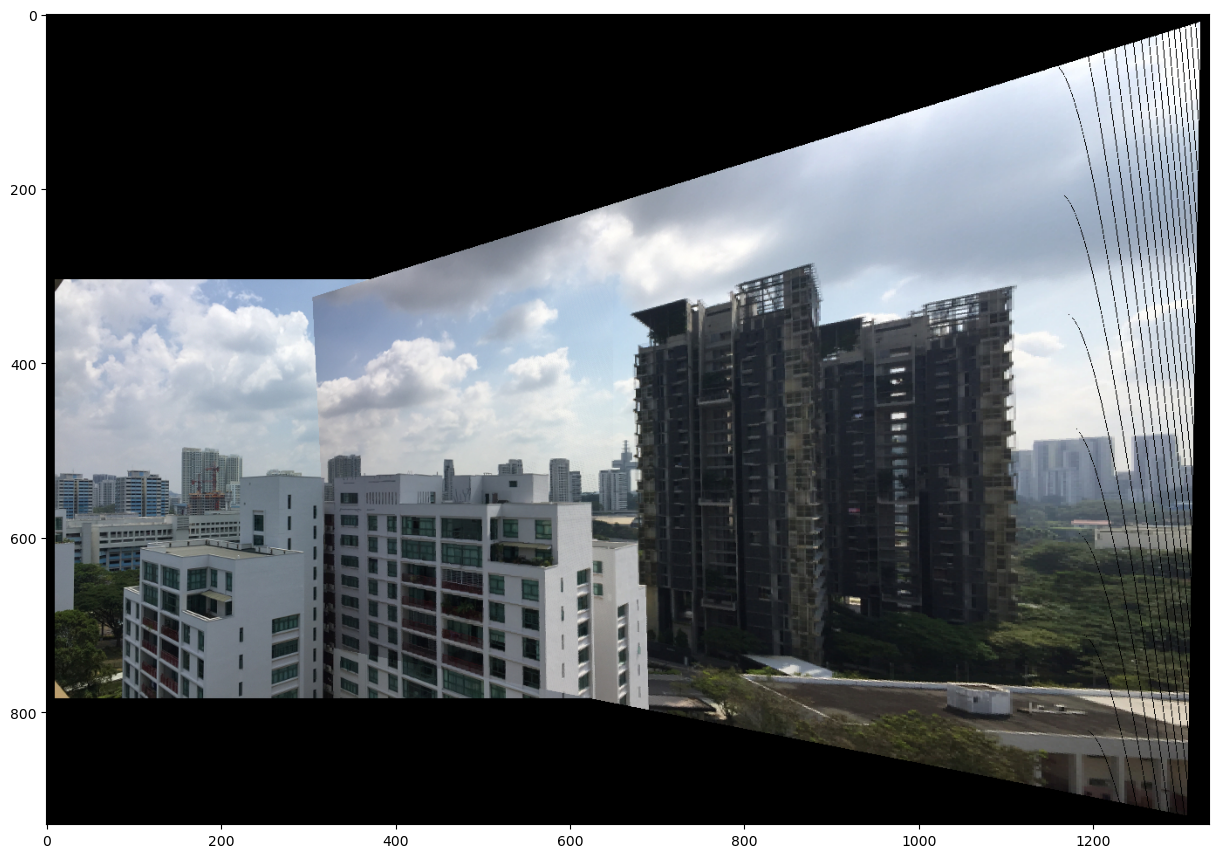

In [24]:
# Use SIFT to find keypoints and match the keypoints
[kpm, kp1, kp2] = SIFT(im1, im2)

# Using RANSAC to find best homography
# looping until best matches are done
while True:
    HH, match_best = homo_ransac(kp1, kp2, kpm, 100000)

    if len(match_best) > 0:
        break


# compute Homography from the inliers
def HHmat(kp1, kp2, match_best):
    # change the inliers from tuple to list
    N = len(match_best)
    in1 = np.zeros([N, 2])
    in2 = np.zeros([N, 2])

    # Get the coordinate of keypoint
    for i in range(N):
        for j in range(2):
            in1[i] = [kp1[match_best[i].queryIdx].pt[1], kp1[match_best[i].queryIdx].pt[0]]
            in2[i] = [kp2[match_best[i].trainIdx].pt[1], kp2[match_best[i].trainIdx].pt[0]]

    # compare the Homography compute from the random points and the inliers
    in_points = np.concatenate((in1, in2), axis=0)
    H_best = hmat(in_points)
    print(H_best)
    print(HH)

    return H_best, in1, in2


# recalculate H matrix with all inliers
H_best, _, _ = HHmat(kp1, kp2, match_best)

# im2 to im1
Hi = linalg.inv(H_best)

# get canvas and axis compensation
canvas, compensation = get_canvas(img1, img2, Hi)

# show the canvas
# print(compensation)
# plt.figure( figsize=(15,15) )
# plt.imshow(canvas)

# transfer im2 to im1 plane
img12 = trans2im1(canvas, img2, Hi, compensation, 3)
img12 = img12.astype(np.uint8)

# show the sitching image
plt.figure(figsize=(15, 15))
plt.imshow(img12)
im12 = cv2.cvtColor(img12, cv2.COLOR_RGB2BGR)

[[ 4.73732900e+00  1.72171205e+00 -2.35718768e+03]
 [-4.34643310e-02  5.45508753e+00 -2.46986214e+03]
 [-1.11644093e-04  6.96233463e-03  1.00000000e+00]]
[[ 5.58793030e+00 -3.97063948e-02 -2.53292841e+03]
 [ 1.76985272e+00  4.85951282e+00 -2.42235552e+03]
 [ 7.14271137e-03 -8.53495341e-05  1.00000000e+00]]
[-640.0844434989788, 1629.3197198365992, 455.4088536708031, 3130.301761081149]


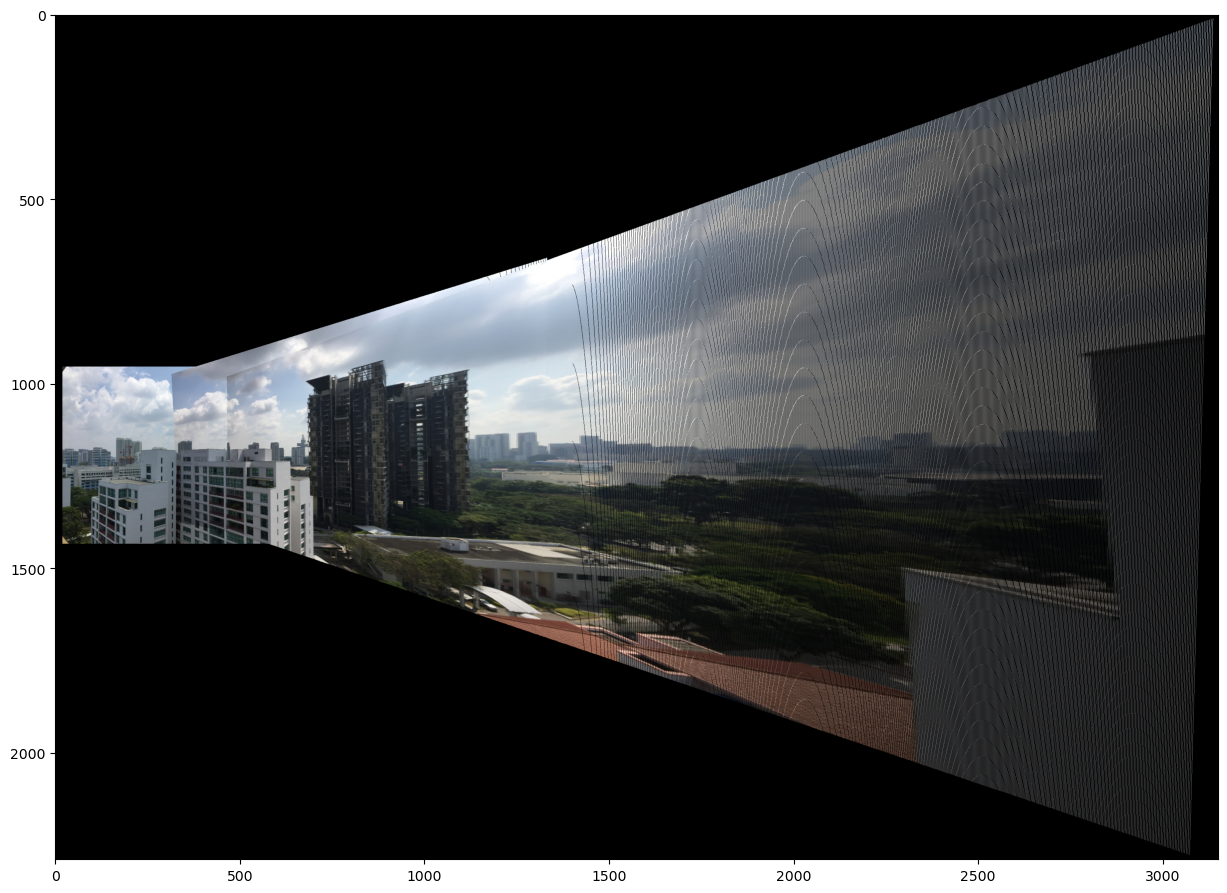

In [25]:
# Use SIFT to find keypoints and match the keypoints
[kpm,kp1,kp2] = SIFT(im12, im3)

# Using RANSAC to find best homography
# looping until best matches are done
while True:
    HH,match_best = homo_ransac(kp1,kp2,kpm,100000)
    
    if len(match_best) > 0:
        break
        
# recalculate H matrix with all inliers
H_best,_,_ = HHmat(kp1,kp2,match_best)

# im2 to im1
Hi = linalg.inv(H_best)

# get canvas and axis compensation
canvas,compensation = get_canvas(img12,img3,Hi)

# show the canvas
# print(compensation)
# plt.figure( figsize=(15,15) )
# plt.imshow(canvas)

# transfer im2 to im1 plane
img123 = trans2im1(canvas,img3,Hi,compensation,5)
img123 = img123.astype(np.uint8)

# show the sitching image
plt.figure( figsize=(15,15) )
plt.imshow(img123)
im123 = cv2.cvtColor(img123, cv2.COLOR_RGB2BGR)

[[ 4.70106612e+00  1.71041425e+00 -5.41311036e+03]
 [-4.64832002e-02  5.41885089e+00 -2.47771860e+03]
 [-1.23805511e-04  6.92822001e-03  1.00000000e+00]]
[[ 5.40602649e+00 -4.24948578e-02 -2.47657727e+03]
 [ 1.70702381e+00  4.68770093e+00 -5.39852606e+03]
 [ 6.91023162e-03 -1.25996614e-04  1.00000000e+00]]
[-0.3963930011953515, 2286.2339421621064, 465.66458033111627, 3165.8844148341072]


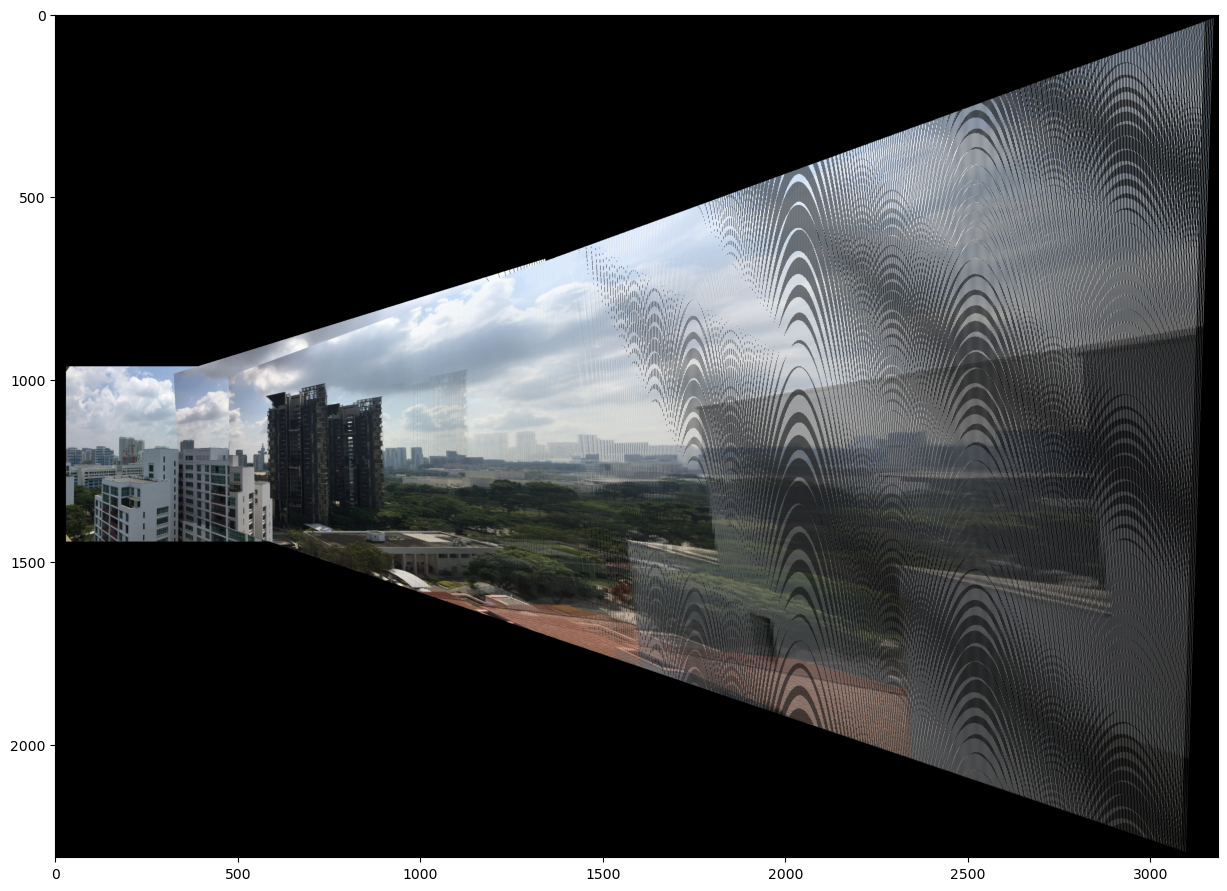

In [26]:
# Use SIFT to find keypoints and match the keypoints
[kpm,kp1,kp2] = SIFT(im123, im3)

# Using RANSAC to find best homography
# looping until best matches are done
while True:
    HH,match_best = homo_ransac(kp1,kp2,kpm,100000)
    
    if len(match_best) > 0:
        break
        
# recalculate H matrix with all inliers
H_best,_,_ = HHmat(kp1,kp2,match_best)

# im2 to im1
Hi = linalg.inv(H_best)

# get canvas and axis compensation
canvas,compensation = get_canvas(img123,img4,Hi)

# show the canvas
# print(compensation)
# plt.figure( figsize=(15,15) )
# plt.imshow(canvas)

# transfer im2 to im1 plane
img1234 = trans2im1(canvas,img4,Hi,compensation,5)
img1234 = img1234.astype(np.uint8)

# show the sitching image
plt.figure( figsize=(15,15) )
plt.imshow(img1234)
im1234 = cv2.cvtColor(img1234, cv2.COLOR_RGB2BGR)

[[ 1.09318937e+00  8.75586757e-02 -5.51292547e+00]
 [-1.70894687e-02  1.22310830e+00 -1.29050359e+02]
 [-9.83538874e-05  3.88594996e-04  1.00000000e+00]]
[[ 1.21803698e+00 -1.74047290e-02 -1.28285711e+02]
 [ 8.63253095e-02  1.08920657e+00 -5.05711513e+00]
 [ 3.81760873e-04 -1.02489011e-04  1.00000000e+00]]
[-58.39180655811588, 492.2223168127242, 105.46260345717978, 791.9972181006526]


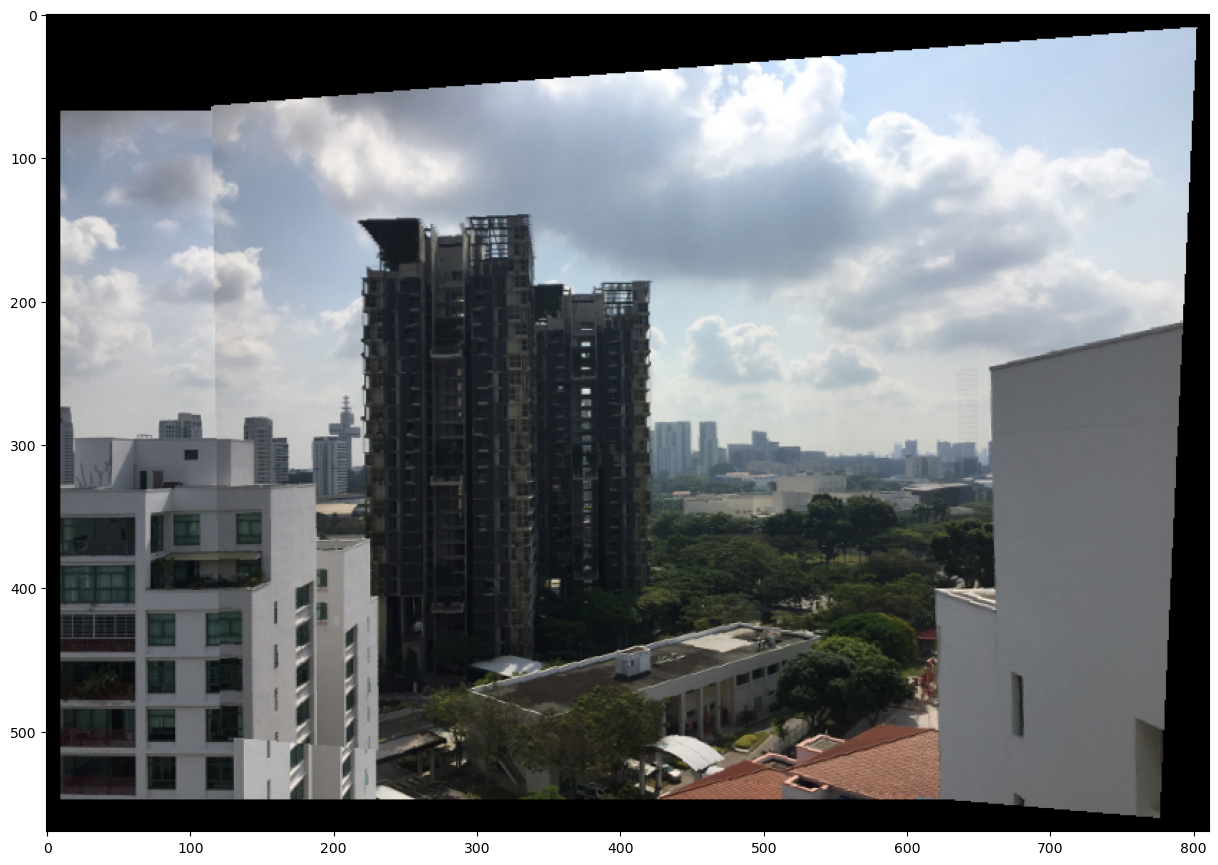

In [27]:
# Use SIFT to find keypoints and match the keypoints
[kpm,kp1,kp2] = SIFT(im3, im4)

# Using RANSAC to find best homography
# looping until best matches are done
while True:
    HH,match_best = homo_ransac(kp1,kp2,kpm,100000)
    
    if len(match_best) > 0:
        break
        
# recalculate H matrix with all inliers
H_best,_,_ = HHmat(kp1,kp2,match_best)

# im4 to im3
Hi = linalg.inv(H_best)

# get canvas and axis compensation
canvas,compensation = get_canvas(img3,img4,Hi)

# show the canvas
# print(compensation)
# plt.figure( figsize=(15,15) )
# plt.imshow(canvas)

# transfer im4 to im3 plane
img34 = trans2im1(canvas,img4,Hi,compensation,3)
img34 = img34.astype(np.uint8)

# show the sitching image
plt.figure( figsize=(15,15) )
plt.imshow(img34)
im34 = cv2.cvtColor(img34, cv2.COLOR_RGB2BGR)

[[ 8.31865549e-01 -1.04260329e-01 -3.87509622e+00]
 [-4.50330360e-02  6.81728772e-01  1.75537587e+02]
 [-8.61393582e-05 -4.54064477e-04  1.00000000e+00]]
[[ 6.83870538e-01 -4.55013993e-02  1.75592805e+02]
 [-1.02355973e-01  8.32981502e-01 -4.48557461e+00]
 [-4.48677693e-04 -8.73007377e-05  1.00000000e+00]]
[-27.84409902764338, 582.6456792143639, -259.3281942289393, 477.0106474220737]


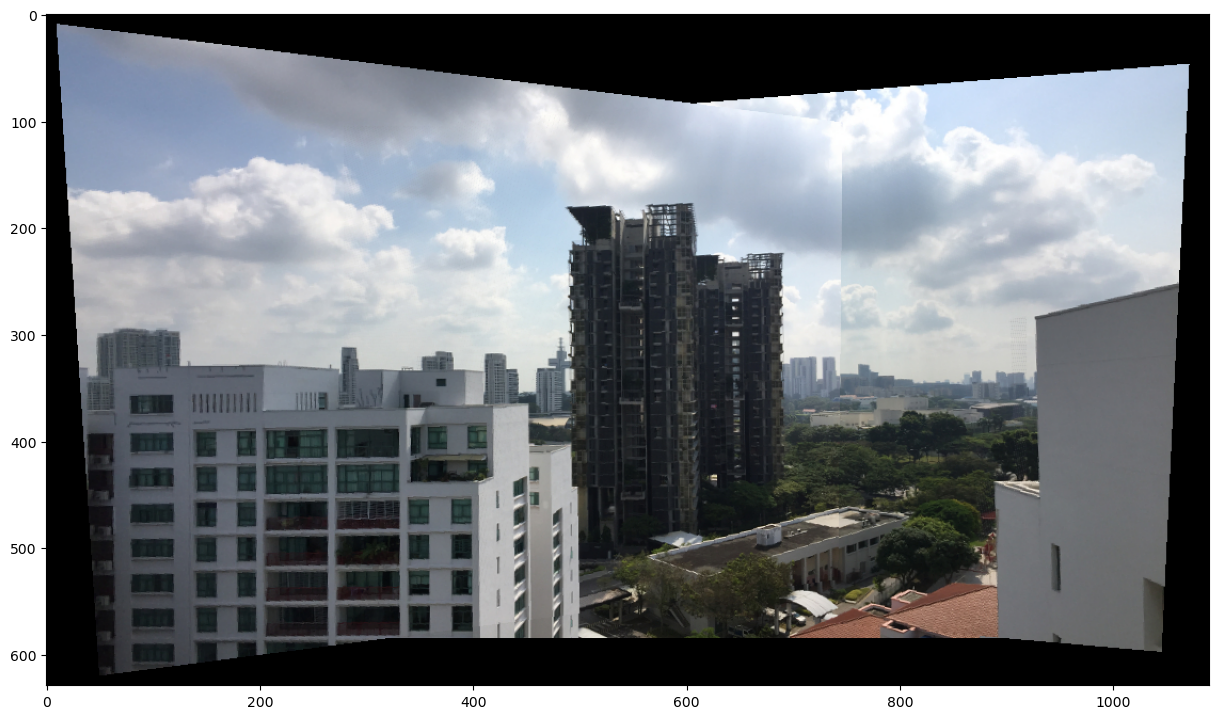

In [28]:
# Use SIFT to find keypoints and match the keypoints
[kpm,kp1,kp2] = SIFT(im34, im2)

# Using RANSAC to find best homography
# looping until best matches are done
while True:
    HH,match_best = homo_ransac(kp1,kp2,kpm,100000)
    
    if len(match_best) > 0:
        break
        
# recalculate H matrix with all inliers
H_best,_,_ = HHmat(kp1,kp2,match_best)

# im2 to im34
Hi = linalg.inv(H_best)

# get canvas and axis compensation
canvas,compensation = get_canvas(img34,img2,Hi)

# show the canvas
# print(compensation)
# plt.figure( figsize=(15,15) )
# plt.imshow(canvas)

# transfer im2 to im34 plane
img342 = trans2im1(canvas,img2,Hi,compensation,3)
img342 = img342.astype(np.uint8)

# show the sitching image
plt.figure( figsize=(15,15) )
plt.imshow(img342)
im342 = cv2.cvtColor(img342, cv2.COLOR_RGB2BGR)

[[ 6.14738969e-01 -2.26452888e-01  2.27402681e+01]
 [-1.43517821e-02  1.26349594e-01  2.95737529e+02]
 [-2.81389446e-05 -9.40264385e-04  1.00000000e+00]]
[[ 1.21833543e-01 -1.31128268e-02  2.97090272e+02]
 [-2.30107881e-01  6.22020847e-01  2.09718633e+01]
 [-9.50767185e-04 -1.83520668e-05  1.00000000e+00]]
[-938.4835839823213, 1504.4715464349965, -2447.229388849288, 472.1231145161359]


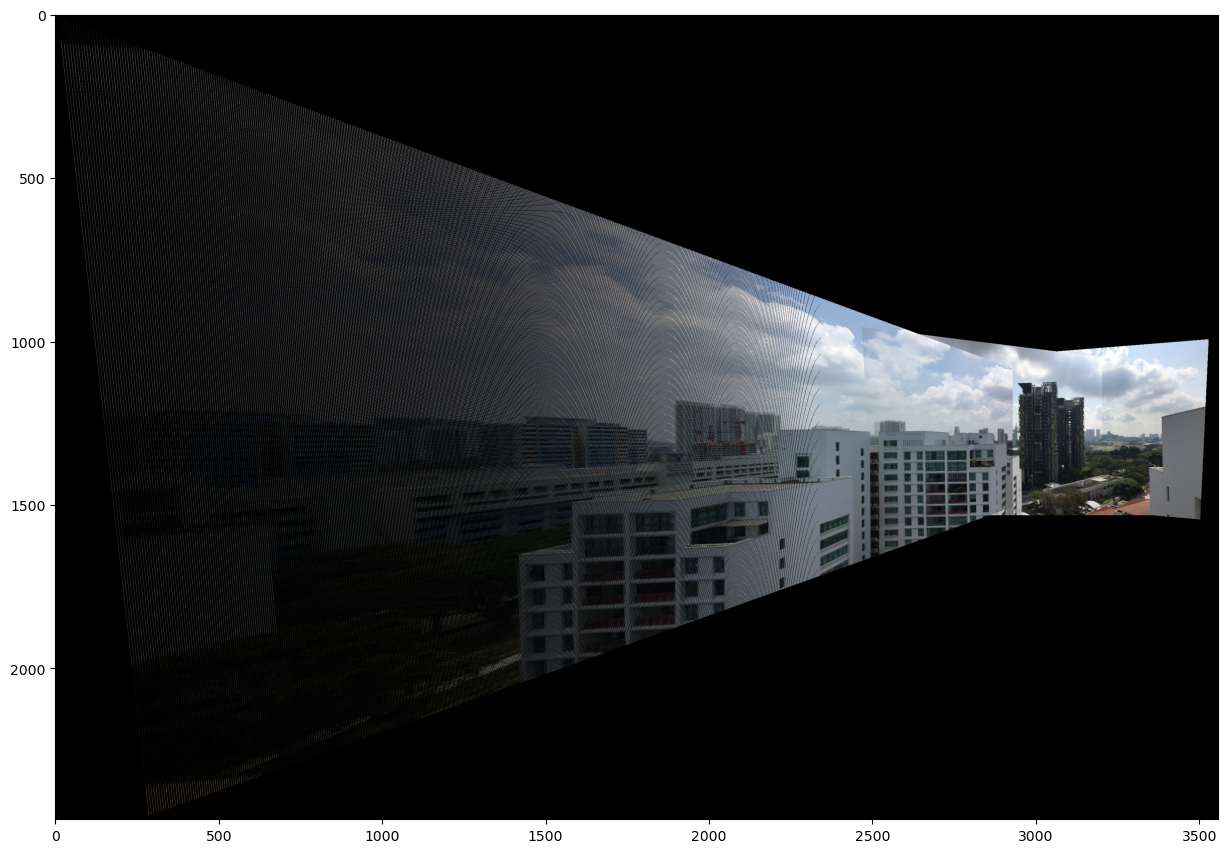

In [29]:
# Use SIFT to find keypoints and match the keypoints
[kpm,kp1,kp2] = SIFT(im342, im1)

# Using RANSAC to find best homography
# looping until best matches are done
while True:
    HH,match_best = homo_ransac(kp1,kp2,kpm,100000)
    
    if len(match_best) > 0:
        break
        
# recalculate H matrix with all inliers
H_best,_,_ = HHmat(kp1,kp2,match_best)

# im1 to im342
Hi = linalg.inv(H_best)

# get canvas and axis compensation
canvas,compensation = get_canvas(img342,img1,Hi)

# show the canvas
# print(compensation)
# plt.figure( figsize=(15,15) )
# plt.imshow(canvas)

# transfer im1 to im342 plane
img3421 = trans2im1(canvas,img1,Hi,compensation,3)
img3421 = img3421.astype(np.uint8)

# show the sitching image
plt.figure( figsize=(15,15) )
plt.imshow(img3421)
im3421 = cv2.cvtColor(img3421, cv2.COLOR_RGB2BGR)

[[-4.98021358e-01 -1.14739805e-01  8.95139716e+02]
 [-2.40452814e-02 -5.09242176e-01  1.59218981e+03]
 [-1.27782274e-04 -4.07269249e-04  1.00000000e+00]]
[[-5.25146530e-01 -2.59576179e-02  1.64304127e+03]
 [-1.14453940e-01 -5.18664892e-01  9.16447389e+02]
 [-4.09514321e-04 -1.36186616e-04  1.00000000e+00]]
[954.5638468647787, 1936.255190417673, 3047.206288089258, 3774.922994820396]


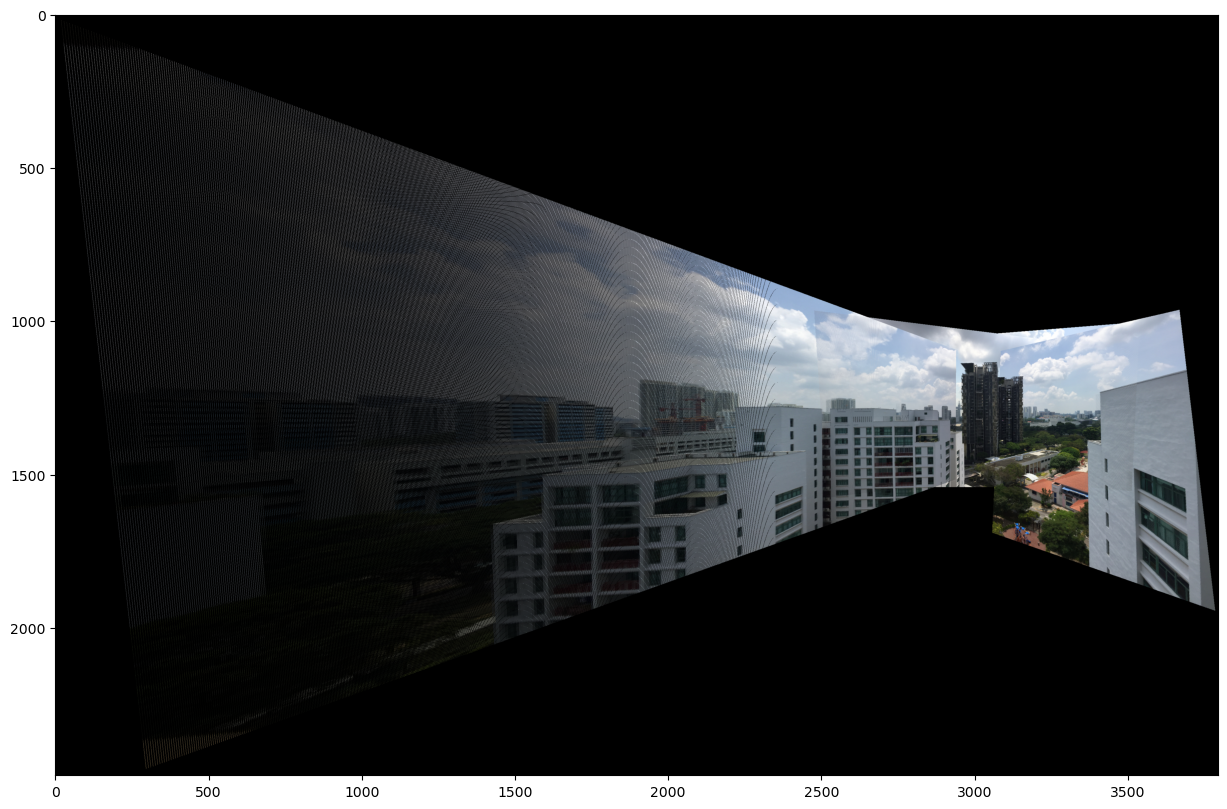

In [30]:
# Use SIFT to find keypoints and match the keypoints
[kpm,kp1,kp2] = SIFT(im3421, im5)

# Using RANSAC to find best homography
# looping until best matches are done
while True:
    HH,match_best = homo_ransac(kp1,kp2,kpm,100000)
    
    if len(match_best) > 0:
        break
        
# recalculate H matrix with all inliers
H_best,_,_ = HHmat(kp1,kp2,match_best)

# im5 to im3421
Hi = linalg.inv(H_best)

# get canvas and axis compensation
canvas,compensation = get_canvas(img3421,img5,Hi)

# show the canvas
# print(compensation)
# plt.figure( figsize=(15,15) )
# plt.imshow(canvas)

# transfer im5 to im3421 plane
img_all = trans2im1(canvas,img5,Hi,compensation,3)
img_all = img_all.astype(np.uint8)

# show the sitching image
plt.figure( figsize=(15,15) )
plt.imshow(img_all)
im_all = cv2.cvtColor(img_all, cv2.COLOR_RGB2BGR)

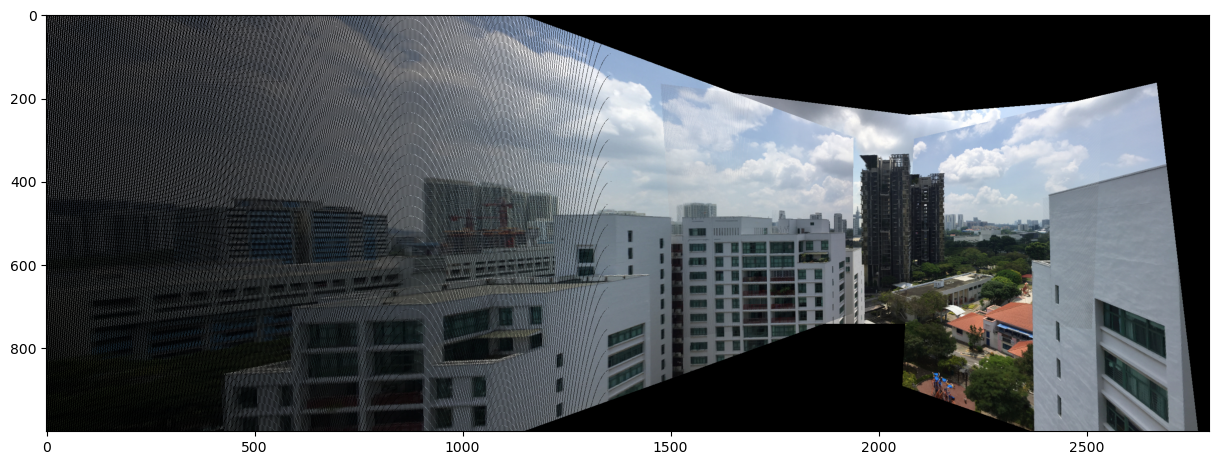

In [31]:
img_cut = img_all[800:1800,1000:,:]
# show the cliped image
plt.figure( figsize=(15,15) )
plt.imshow(img_cut)